# Kingman coalescent and the Newick format

Authors:
- Alex Zarebski @aezarebski
- Gerry Tonkin-Hill @gtonkinhill

Date: 2018-10-03

In this notebook we implement the Kingman coalescent and implement some functions for working with trees inspired by Newick format. Newick format is a widely used way to represent tree data structures. Having the genealogy in Newick format makes it easy to read into `ape` --- a popular package in R for working with genealogies --- and use the visualisation functionality it provides. 

In [1]:
library(ape)

## Model and implementation

Given we have `k` copies of the gene in a population of size `pop_size` the probability of at least one pair coming from the same parent is *approximately* `0.25 * k * (k - 1) / pop_size`. Using discrete generations would suggest a geometric number of generations until the first coalescence where the probability of coalesence in each generation is this value. We can approximate the geometric distribution with an exponential distribution with this rate.

In [2]:
coalescent_rate <- function(k, pop_size) {
    0.25 * k * (k - 1) / pop_size
}

The following functions, `leaf_node` and `branch_node` are helpers to work with trees.

In [3]:
leaf_node <- function(name, time) {
    list(type = "leaf", name = name, time = time)
}

In [4]:
branch_node <- function(name, children, time) {
    list(type = "branch",
         name = name,
         children = children,
         time = time,
         lengths = c(time - children[[1]]$time,
                     time - children[[2]]$time))
}

Taking two nodes and linking them as the children of a parent is achieved with the following function.

In [5]:
binary_parent <- function(child1, child2, time) {
    parent_name <- paste(child1$name, child2$name, sep = "-")
    branch_node(parent_name, list(child1, child2), time)
}

Start by setting up a little sample population in a larger population to work on

In [6]:
current_time <- 0
sampled_population <- list(leaf_node("beth", current_time),
                           leaf_node("gerry", current_time),
                           leaf_node("morty", current_time),
                           leaf_node("summer", current_time))
population_size <- 100

k <- +Inf

Until the population has multiple individuals who have not coalesed continue to coalese individuals.

In [7]:
while (k > 2) {
    k <- length(sampled_population)
    coalescent_time <- rexp(1, coalescent_rate(k, population_size))
    current_time <- current_time + coalescent_time
    ixs <- sample.int(k, size = 2)
    parent_node <- binary_parent(sampled_population[[ixs[1]]], sampled_population[[ixs[2]]], current_time)
    if (k > 2) {
        sampled_population <- c(list(parent_node), sampled_population[-ixs])
    } else {
        sampled_population <- parent_node
    }
}


The following function recursively constructs a Newick representation of the tree.

In [8]:
newick_helper <- function(node) {
    if (node$type == "leaf") {
        node$name
    } else if (node$type == "branch") {
        sprintf("(%s:%f,%s:%f)%s",
                newick_helper(node$children[[1]]),
                node$lengths[1],
                newick_helper(node$children[[2]]),
                node$lengths[2],
                node$name)
    }
}

newick <- function(node) {
    sprintf("%s;", newick_helper(node))
}

In [9]:
demo_tree <- read.tree(text = newick(sampled_population))

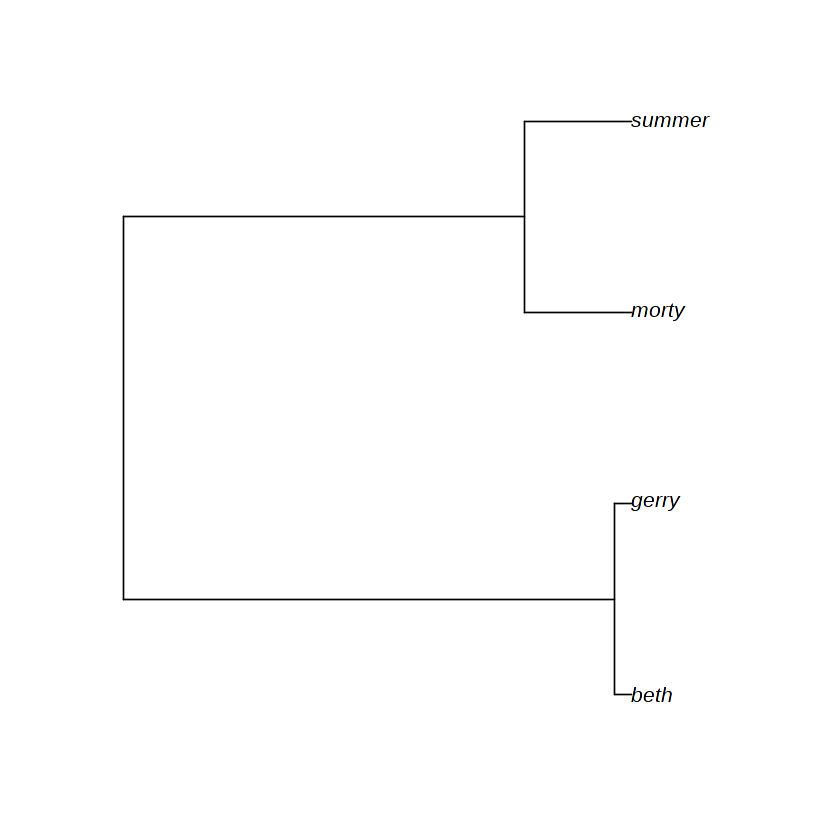

In [10]:
plot(demo_tree)